In [2]:
import os
import glob
import pandas as pd
import re

# 風洞運転周波数(Hz) -> 設計風速(m/s) の対応辞書
freq_to_speed = {0: 0, 14: 6.1, 26: 12.2, 38: 18.3, 50: 24.4}

folder = r"./data/calib"
pattern = os.path.join(folder, "*_summary.csv")
files = glob.glob(pattern)

results = []

for filepath in files:
    filename = os.path.basename(filepath)
    m = re.match(r"(\d+)_([0-9]+)_(up|dw)_summary\.csv", filename)
    if not m:
        continue
    meas_num, freq_str, direction = m.groups()
    freq = int(freq_str)

    # ファイル読み込み
    with open(filepath, "r", encoding="utf-8") as f:
        lines = [line.strip() for line in f]

    # 気圧
    pressure = float(
        next(line for line in lines if line.startswith("Air pressure")).split(",")[1]
    )

    # ヘッダー行（計測日時＋統計量ヘッダー）を探す
    header_idx = next(
        i
        for i, line in enumerate(lines)
        if re.match(r"\d{4}/\d{2}/\d{2}_\d{2}:\d{2}:\d{2},Mean", line)
    )
    header_parts = lines[header_idx].split(",")
    timestamp_str = header_parts[0]  # "YYYY/MM/DD_HH:MM:SS"

    # 平均電圧 (U, V) を直接抽出
    mean_ch1 = mean_ch2 = None
    for line in lines[header_idx + 1 :]:
        if line.startswith("U,"):
            mean_ch1 = float(line.split(",")[1])
        elif line.startswith("V,"):
            mean_ch2 = float(line.split(",")[1])
        if mean_ch1 is not None and mean_ch2 is not None:
            break

    # 設計風速
    design_speed = freq_to_speed.get(freq)

    # 温度データ読み込み
    date_part = timestamp_str.split("_")[0]  # "YYYY/MM/DD"
    yy, mm, dd = date_part[2:4], date_part[5:7], date_part[8:10]
    temp_file = os.path.join(folder, f"temperature_{yy}{mm}{dd}.csv")
    temp_c = None
    if os.path.exists(temp_file):
        temp_df = pd.read_csv(
            temp_file, header=None, names=["DateTime", "Temperature_C"]
        )
        target_time = timestamp_str.replace("_", " ")
        matched = temp_df[temp_df["DateTime"] == target_time]
        if not matched.empty:
            temp_c = float(matched["Temperature_C"].iloc[0])

    results.append(
        {
            "Measurement_Number": int(meas_num),
            "Frequency": freq,
            "Direction": direction,
            "Timestamp": timestamp_str,
            "Pressure_hPa": pressure,
            "Mean_Ch1_Voltage_V": mean_ch1,
            "Mean_Ch2_Voltage_V": mean_ch2,
            "Design_Wind_Speed_m_s": design_speed,
            "Temperature_C": temp_c,
        }
    )

result_df = pd.DataFrame(results)
print(result_df)

     Measurement_Number  Frequency Direction            Timestamp  \
0                     1          0        dw  2025/04/10_14:31:49   
1                     1          0        up  2025/04/10_14:26:43   
2                     1         14        dw  2025/04/10_14:31:15   
3                     1         14        up  2025/04/10_14:27:12   
4                     1         26        dw  2025/04/10_14:30:34   
..                  ...        ...       ...                  ...   
155                  16         26        up  2025/04/10_16:53:45   
156                  16         38        dw  2025/04/10_16:55:33   
157                  16         38        up  2025/04/10_16:54:21   
158                  16         50        dw  2025/04/10_16:55:08   
159                  16         50        up  2025/04/10_16:54:53   

     Pressure_hPa  Mean_Ch1_Voltage_V  Mean_Ch2_Voltage_V  \
0          1005.2            1.570463            1.856334   
1          1005.2            1.565400            

In [3]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# 欠損チェック (Temperature, Voltage, Design Speed)
# print("全サンプル数:", len(result_df))
# print("  • Temperature_C missing:", result_df["Temperature_C"].isnull().sum())
# print("  • Ch1 Voltage missing:", result_df["Mean_Ch1_Voltage_V"].isnull().sum())
# print("  • Ch2 Voltage missing:", result_df["Mean_Ch2_Voltage_V"].isnull().sum())
# print(
#     "  • Design_Wind_Speed_m_s missing:",
#     result_df["Design_Wind_Speed_m_s"].isnull().sum(),
# )

# 欠損行を削除
df2 = result_df.dropna(
    subset=[
        "Temperature_C",
        "Mean_Ch1_Voltage_V",
        "Mean_Ch2_Voltage_V",
        "Design_Wind_Speed_m_s",
    ]
).copy()
# print("欠損削除後サンプル数:", len(df2))

# u, v, U45 を計算
df2["u"] = df2["Design_Wind_Speed_m_s"].astype(float)
df2["v"] = 0.0
df2["U45_1"] = df2["u"] + df2["v"]
df2["U45_2"] = df2["u"] - df2["v"]


# デザイン行列
def design_matrix(T, V):
    powers = np.vstack([V**j for j in range(5)]).T
    return np.hstack([powers, (T[:, None] * powers)])


# キャリブレーション関数
def calibrate_channel(T, V, U45, label, design_speeds):
    """
    T : ndarray  (温度 [°C])
    V : ndarray  (電圧 [V])
    U45 : ndarray (ターゲット速度 [m/s])
    label : str   ("Sensor-1" など)
    design_speeds : ndarray (= u)  設定風速 [m/s]
    """
    X = design_matrix(T, V)

    # 全データ最小二乗（参考）
    coeffs, *_ = np.linalg.lstsq(X, U45, rcond=None)
    pretty_print_coeffs(coeffs, label)

    # 5-Fold KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmses = []

    # ↓ 交差検証中に誤差をすべて蓄積
    all_errs = []  # 絶対誤差
    all_speeds = []  # 設定風速 u
    all_temps = []  # 温度 T

    for train_idx, test_idx in kf.split(X):
        beta, *_ = np.linalg.lstsq(X[train_idx], U45[train_idx], rcond=None)
        pred = X[test_idx] @ beta
        true = U45[test_idx]

        errs = np.abs(true - pred)
        all_errs.extend(errs)  # 誤差 |U_true − U_pred|
        all_speeds.extend(design_speeds[test_idx])  # 対応する設定風速 u
        all_temps.extend(T[test_idx])  # 対応する温度

        rmses.append(np.sqrt(mean_squared_error(true, pred)))

    print(f"=== {label} 平均 CV-RMSE: {np.mean(rmses):.3f} m/s ===")

    # ---------- 速度ごとに最大誤差とその温度を集計 ----------
    # 辞書: {speed : (max_error, temp_at_max)}
    max_err_dict = {}
    for err, spd, temp in zip(all_errs, all_speeds, all_temps):
        # speed を丸めてキー化（小数点誤差対策）
        key = round(float(spd), 3)
        if key not in max_err_dict or err > max_err_dict[key][0]:
            max_err_dict[key] = (err, temp)

    # 表示
    print(f"=== {label} 速度別 最大絶対誤差 & 温度 ===")
    for spd in sorted(max_err_dict.keys()):
        err, temp = max_err_dict[spd]
        print(
            f"  •  u = {spd:>5.1f} m/s :  |err|max = {err:6.3f} m/s  @  T = {temp:4.1f} °C"
        )

    return coeffs


# 表示用ヘルパ関数
def pretty_print_coeffs(coeffs, label):
    """
    coeffs : 1D array, len=10
        coeffs[0:5] = a0j  (温度 0 次の電圧多項式係数, j=0…4)
        coeffs[5:10]= a1j  (温度 1 次の電圧多項式係数, j=0…4)
    label  : str  センサ名
    """
    print(f"\n=== {label} 校正係数  (モデル: U₄₅,k = Σⱼ (a₀ⱼ + a₁ⱼ·T)·Vᵏⱼ) ===")
    print("  j |        a0j (常温項)      |        a1j (T 項)")
    print("----+--------------------------+--------------------------")
    for j in range(5):
        a0 = coeffs[j]
        a1 = coeffs[j + 5]
        print(f"  {j} | {a0:>22.6e} | {a1:>22.6e}")
    print()  # 改行だけ追加


# 6) 実行
design_speeds = df2["u"].to_numpy()

coeffs_1 = calibrate_channel(
    df2["Temperature_C"].to_numpy(),
    df2["Mean_Ch1_Voltage_V"].to_numpy(),
    df2["U45_1"].to_numpy(),
    "Sensor-1",
    design_speeds,
)

coeffs_2 = calibrate_channel(
    df2["Temperature_C"].to_numpy(),
    df2["Mean_Ch2_Voltage_V"].to_numpy(),
    df2["U45_2"].to_numpy(),
    "Sensor-2",
    design_speeds,
)



=== Sensor-1 校正係数  (モデル: U₄₅,k = Σⱼ (a₀ⱼ + a₁ⱼ·T)·Vᵏⱼ) ===
  j |        a0j (常温項)      |        a1j (T 項)
----+--------------------------+--------------------------
  0 |          -5.582401e+01 |           2.806334e+00
  1 |           9.111147e+01 |          -4.545191e+00
  2 |          -5.322099e+01 |           2.607626e+00
  3 |           1.316683e+01 |          -6.356740e-01
  4 |          -1.141452e+00 |           5.922406e-02

=== Sensor-1 平均 CV-RMSE: 0.087 m/s ===
=== Sensor-1 速度別 最大絶対誤差 & 温度 ===
  •  u =   0.0 m/s :  |err|max =  0.051 m/s  @  T = 21.6 °C
  •  u =   6.1 m/s :  |err|max =  0.124 m/s  @  T = 24.5 °C
  •  u =  12.2 m/s :  |err|max =  0.153 m/s  @  T = 22.3 °C
  •  u =  18.3 m/s :  |err|max =  0.211 m/s  @  T = 21.7 °C
  •  u =  24.4 m/s :  |err|max =  0.415 m/s  @  T = 21.8 °C

=== Sensor-2 校正係数  (モデル: U₄₅,k = Σⱼ (a₀ⱼ + a₁ⱼ·T)·Vᵏⱼ) ===
  j |        a0j (常温項)      |        a1j (T 項)
----+--------------------------+--------------------------
  0 |          -1.263951e

In [4]:
# --- セル3 : 全データモデルでの誤差検証 (平均絶対誤差も追加) -------------


def full_data_error_report(T, V, U45, coeffs, speeds, label):
    """
    全データでフィットした coeffs を用い、誤差を評価して表示
      • 全データ RMSE
      • 速度別 最大絶対誤差 & その温度
      • 速度別 平均絶対誤差
    """
    X_full = design_matrix(T, V)
    pred = X_full @ coeffs
    abs_errs = np.abs(U45 - pred)

    # --- 全データ RMSE ---
    rmse_full = np.sqrt(np.mean((U45 - pred) ** 2))
    print(f"\n=== {label} 全データ RMSE: {rmse_full:.3f} m/s ===")

    # --- 速度別集計 ---
    stats = {}  # {speed: {"max":(err,temp), "sum":val, "n":count}}
    for err, spd, temp in zip(abs_errs, speeds, T):
        key = round(float(spd), 3)  # 速度をキー化
        if key not in stats:
            stats[key] = {"max": (err, temp), "sum": err, "n": 1}
        else:
            # max
            if err > stats[key]["max"][0]:
                stats[key]["max"] = (err, temp)
            # sum & n
            stats[key]["sum"] += err
            stats[key]["n"] += 1

    # --- 表示 ---
    print(f"=== {label} 速度別 誤差統計 (全データモデル) ===")
    print("u[m/s] | |err|max [m/s] @ T[°C] | |err|avg [m/s]")
    for spd in sorted(stats.keys()):
        max_err, temp_at_max = stats[spd]["max"]
        avg_err = stats[spd]["sum"] / stats[spd]["n"]
        print(
            f"{spd:>5.1f}   |  {max_err:6.3f}  @ {temp_at_max:4.1f} |   {avg_err:6.3f}"
        )


# ---------- Sensor-1 ----------
full_data_error_report(
    df2["Temperature_C"].to_numpy(),
    df2["Mean_Ch1_Voltage_V"].to_numpy(),
    df2["U45_1"].to_numpy(),
    coeffs_1,
    design_speeds,
    "Sensor-1",
)

# ---------- Sensor-2 ----------
full_data_error_report(
    df2["Temperature_C"].to_numpy(),
    df2["Mean_Ch2_Voltage_V"].to_numpy(),
    df2["U45_2"].to_numpy(),
    coeffs_2,
    design_speeds,
    "Sensor-2",
)



=== Sensor-1 全データ RMSE: 0.084 m/s ===
=== Sensor-1 速度別 誤差統計 (全データモデル) ===
u[m/s] | |err|max [m/s] @ T[°C] | |err|avg [m/s]
  0.0   |   0.028  @ 21.6 |    0.007
  6.1   |   0.115  @ 24.5 |    0.035
 12.2   |   0.140  @ 22.3 |    0.047
 18.3   |   0.207  @ 21.7 |    0.064
 24.4   |   0.321  @ 21.8 |    0.113

=== Sensor-2 全データ RMSE: 0.085 m/s ===
=== Sensor-2 速度別 誤差統計 (全データモデル) ===
u[m/s] | |err|max [m/s] @ T[°C] | |err|avg [m/s]
  0.0   |   0.036  @ 21.6 |    0.010
  6.1   |   0.062  @ 20.8 |    0.025
 12.2   |   0.165  @ 21.4 |    0.047
 18.3   |   0.254  @ 21.7 |    0.068
 24.4   |   0.347  @ 21.8 |    0.120


C:\Users\3thou\AppData\Local\Temp\ipykernel_25148\2552614097.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", len(temp_vals))


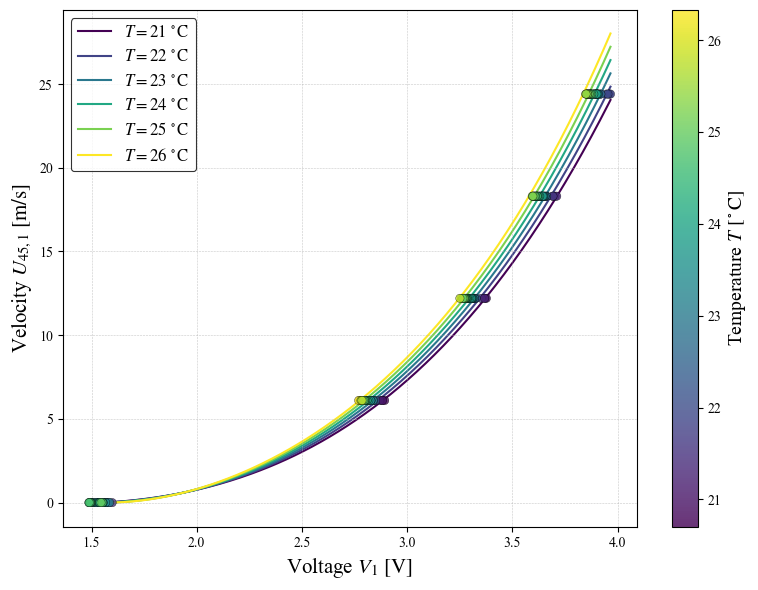

C:\Users\3thou\AppData\Local\Temp\ipykernel_25148\2552614097.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", len(temp_vals))


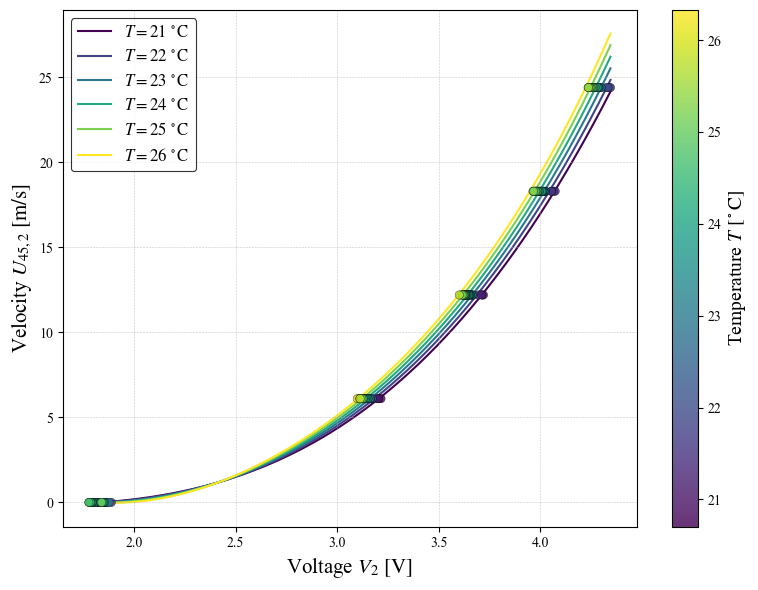

In [5]:
# --- セル4: Sensorごとに U45_k vs V_k をプロット関数化 ---
import os
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# フォント設定
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"


def plot_sensor_calibration(k, coeffs, df, temp_vals=[21, 22, 23, 24, 25, 26]):
    """
    Sensor k (1 or 2) の校正曲線と計測データを
    U45_k vs V_k でプロット・保存する関数
    """
    # 列名
    voltage_col = f"Mean_Ch{k}_Voltage_V"
    u45_col = f"U45_{k}"

    # 描画範囲
    V_min, V_max = df[voltage_col].min(), df[voltage_col].max()
    V_grid = np.linspace(V_min, V_max, 300)

    # 校正モデル U45_k(T,V)
    a0 = coeffs[:5]
    a1 = coeffs[5:]

    def U45_model(T, V):
        V_p = np.vstack([V**j for j in range(5)])  # (5, N)
        return np.sum((a0[:, None] + a1[:, None] * T) * V_p, axis=0)

    # プロット
    fig, ax = plt.subplots(figsize=(8, 6))
    cmap = cm.get_cmap("viridis", len(temp_vals))

    # 校正曲線（背面）
    for idx, T in enumerate(temp_vals):
        ax.plot(
            V_grid,
            U45_model(T, V_grid),
            label=rf"$T={T:.0f}\,\mathrm{{^\circ C}}$",
            color=cmap(idx),
            zorder=1,
        )

    # 計測データ（前面）
    scatter = ax.scatter(
        df[voltage_col],
        df[u45_col],
        c=df["Temperature_C"],
        cmap="viridis",
        edgecolors="k",
        linewidths=0.3,
        alpha=0.8,
        zorder=2,
    )

    # 軸ラベル
    ax.set_xlabel(rf"Voltage $V_{k}\ \mathrm{{[V]}}$", fontsize=15)
    ax.set_ylabel(rf"Velocity $U_{{45,{k}}}\ \mathrm{{[m/s]}}$", fontsize=15)
    # ax.set_title(f"Sensor-{k} Calibration Curve")

    # 凡例（黒枠付き）
    legend = ax.legend(frameon=True, edgecolor="black", fontsize=12)
    legend.get_frame().set_linewidth(0.8)

    # カラーバー
    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label(r"Temperature $T\ \mathrm{[^\circ C]}$", fontsize=14)

    # グリッド・余白タイト
    ax.grid(True, linestyle="--", linewidth=0.4, alpha=0.7)
    plt.tight_layout()

    # 保存
    today = date.today().strftime("%m%d")
    out_dir = os.path.join("figure", today)
    os.makedirs(out_dir, exist_ok=True)
    base = f"Sensor{k}_Calibration"
    fig.savefig(os.path.join(out_dir, base + ".png"), dpi=300, bbox_inches="tight")
    fig.savefig(os.path.join(out_dir, base + ".pdf"), bbox_inches="tight")

    plt.show()
    plt.close()


# --- センサー1, 2 をプロット ---
plot_sensor_calibration(1, coeffs_1, df2)
plot_sensor_calibration(2, coeffs_2, df2)


C:\Users\3thou\AppData\Local\Temp\ipykernel_25148\624509965.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")


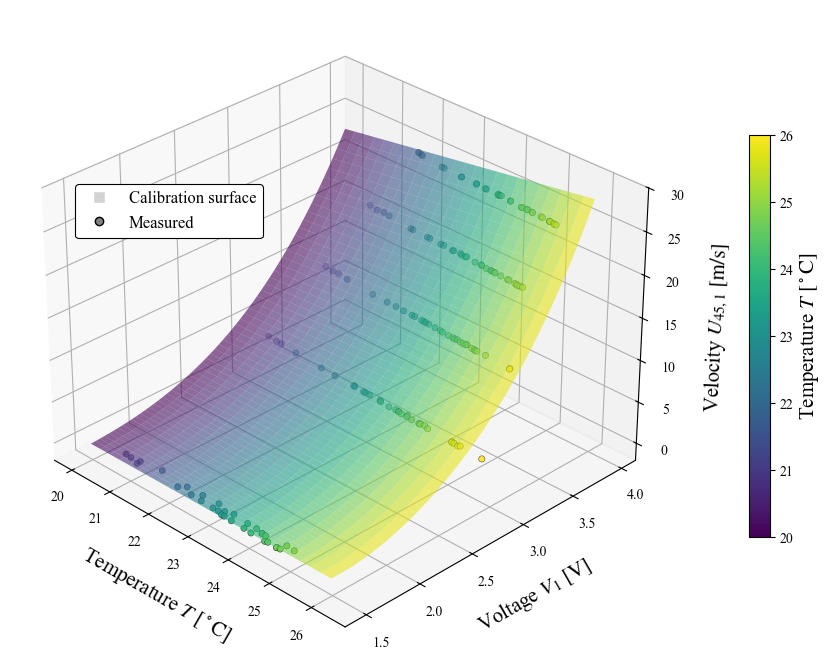

C:\Users\3thou\AppData\Local\Temp\ipykernel_25148\624509965.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")


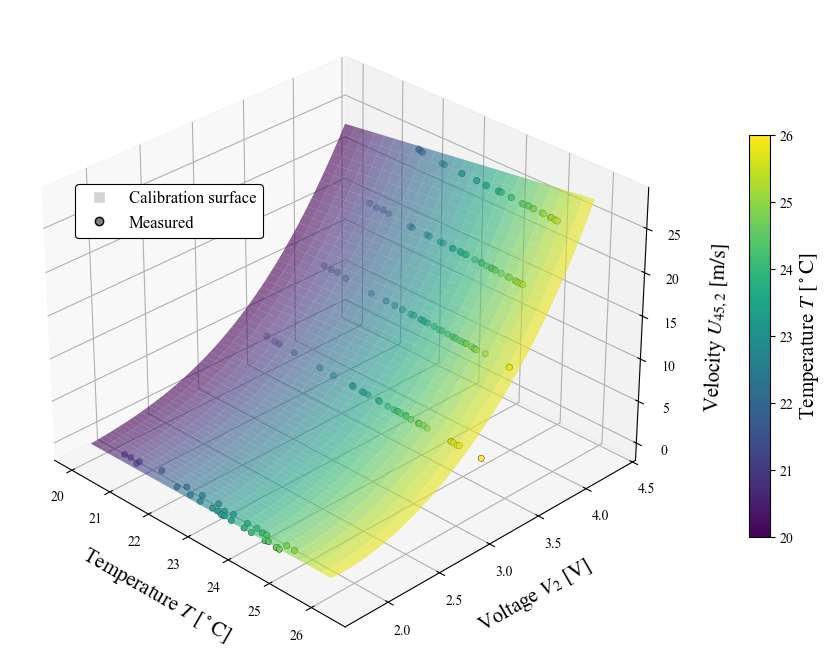

In [9]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"


def plot_sensor_calibration_3d(
    k: int,
    coeffs: np.ndarray,
    df,
    elev: float = 30,
    azim: float = 140,
    T_mesh=np.linspace(20, 26, 25),
    V_mesh_divs: int = 60,
):
    """
    Parameters
    ----------
    k : int
        Sensor number (1 or 2)
    coeffs : np.ndarray
        Length‑10 coefficient array [a00…a04, a10…a14]
    df : pandas DataFrame
        DataFrame df2 with columns Temperature_C, Mean_Ch{k}_Voltage_V, U45_k
    elev, azim : float
        Viewing angles for ax.view_init
    """

    # ---------- 列名 ----------
    v_col = f"Mean_Ch{k}_Voltage_V"
    u45_col = f"U45_{k}"

    # ---------- 校正モデル ----------
    a0, a1 = coeffs[:5], coeffs[5:]

    def U45_model(T, V):
        v_pow = np.vstack([V**j for j in range(5)])  # (5,N)
        return np.sum((a0[:, None] + a1[:, None] * T) * v_pow, axis=0)

    # ---------- メッシュ生成 ----------
    V_lin = np.linspace(df[v_col].min(), df[v_col].max(), V_mesh_divs)
    T_lin = T_mesh
    T_grid, V_grid = np.meshgrid(T_lin, V_lin)  # shape (V_mesh_divs, len(T_mesh))
    # 各列(=温度)ごとに U45
    U_grid = np.zeros_like(T_grid)
    for idx, T_val in enumerate(T_lin):
        U_grid[:, idx] = U45_model(T_val, V_lin)

    # ---------- カラーマップ（温度基準） ----------
    cmap = cm.get_cmap("viridis")
    norm = plt.Normalize(T_lin.min(), T_lin.max())
    facecolors = cmap(norm(T_grid))

    # ---------- FIGURE ----------
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection="3d")

    surf = ax.plot_surface(
        T_grid,
        V_grid,
        U_grid,
        facecolors=facecolors,
        rcount=V_mesh_divs,
        ccount=len(T_lin),
        shade=False,
        linewidth=0,
        alpha=0.6,
        zorder=1,
    )

    # 散布点
    p = ax.scatter(
        df["Temperature_C"],
        df[v_col],
        df[u45_col],
        c=df["Temperature_C"],
        cmap="viridis",
        norm=norm,
        edgecolors="k",
        linewidths=0.3,
        zorder=2,
    )

    # ---------- 軸 & ラベル ----------
    ax.set_xlabel(r"Temperature $T\ \mathrm{[^\circ C]}$", labelpad=10, fontsize=15)
    ax.set_ylabel(rf"Voltage $V_{k}\ \mathrm{{[V]}}$", labelpad=10, fontsize=15)
    ax.set_zlabel(
        rf"Velocity $U_{{45,{k}}}\ \mathrm{{[m/s]}}$", labelpad=10, fontsize=15
    )

    ax.view_init(elev=elev, azim=azim)

    # ---------- カラーバー（温度） ----------
    cbar = fig.colorbar(p, ax=ax, shrink=0.6, pad=0.1)
    cbar.set_label(r"Temperature $T\ \mathrm{[^\circ C]}$", fontsize=15)

    # ---------- 凡例 ----------
    scatter_proxy = plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="gray",
        markeredgecolor="k",
        markersize=6,
    )
    surface_proxy = plt.Line2D(
        [0], [0], marker="s", color="w", markerfacecolor="lightgray", markersize=8
    )
    leg = ax.legend(
        [surface_proxy, scatter_proxy],
        ["Calibration surface", "Measured"],
        frameon=True,
        framealpha=1,
        edgecolor="black",
        loc=(0.1, 0.65),
        fontsize=12,
    )
    leg.get_frame().set_linewidth(0.8)

    plt.tight_layout()

    # ---------- 保存 ----------
    today = date.today().strftime("%m%d")
    out_dir = os.path.join("figure", today)
    os.makedirs(out_dir, exist_ok=True)
    base = f"Sensor{k}_Calibration_3D"
    fig.savefig(os.path.join(out_dir, base + ".png"), dpi=300, bbox_inches="tight")
    fig.savefig(os.path.join(out_dir, base + ".pdf"), bbox_inches="tight")

    plt.show()
    plt.close()


# --------- Sensor‑1, Sensor‑2 ----------
plot_sensor_calibration_3d(1, coeffs_1, df2, elev=30, azim=315)
plot_sensor_calibration_3d(2, coeffs_2, df2, elev=30, azim=315)
